In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/test'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['age'].keys()))
print(len(subs))

830


In [6]:
# Load timeseries

tsfname = '../../PNC_Good/PNC_PowerTS_float2.pkl'

ts = pickle.load(open(tsfname, 'rb'))
print(list(ts.keys()))

['emoid', 'nback', 'rest']


In [46]:
# Get delayed connectivity

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def corrcoef(a, b):
    n = a.shape[1]
    aa = np.einsum('ij,ij->i',a,a)
    bb = np.einsum('ij,ij->i',b,b)
    ab = np.einsum('ij,kj->ik',a,b)
    den = np.expand_dims(aa, 1)*np.expand_dims(bb, 0)
    rho = ab/(den**0.5)
    return rho

def dc(ts):
    c1 = corrcoef(ts,ts)
    c2 = corrcoef(ts[:,1:],ts[:,:-1])
    c3 = corrcoef(ts[:,:-1],ts[:,1:])
#     c4 = corrcoef(ts[:,2:],ts[:,:-2])
#     c5 = corrcoef(ts[:,:-2],ts[:,2:])
#     c = np.stack([c1,c2,c3,c4,c5])
    c = np.stack([c1,c2,c3])
    return np.amax(c, axis=0)

tr = 3
t1 = ts['rest'][f'sub-{subs[0]}']
t1 = butter_bandpass_filter(t1, [0.01, 0.15], 1/tr)
p = corrcoef(t1, t1)
dcp = dc(t1)

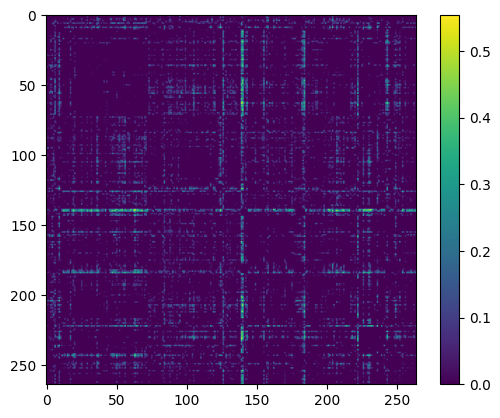

In [47]:
import matplotlib.pyplot as plt

plt.imshow(dcp-p)
plt.colorbar()
plt.show()

In [75]:
import numpy as np

task = 'emoid'
x = []
y = []

for sub in subs:
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
#     t1 = ts[task][f'sub-{sub}']
#     t1 = butter_bandpass_filter(t1, [0.01, 0.15], 1/tr)
#     p = dc(t1)
#     a,b = np.triu_indices(264,1)
#     x.append(p[a,b])
#     y.append(int(demo['age'][sub]))
    y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(830, 34716)
(830,)
[0 0 0 1 0]


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import sys

if '../../LatentSimilarity' not in sys.path:
    sys.path.append('../../LatentSimilarity')
    
from latsim import LatSimClf, LatSimReg
accs = []

for _ in range(10):
    xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.8)

#     clf = LogisticRegression(C=1, max_iter=1000).fit(xtr, ytr)
#     clf = LatSimReg().fit(xtr, ytr, wd=1e-4, ld=1, nepochs=100)
    clf = LatSimClf().fit(xtr, ytr, ld=1, wd=1e-4, nepochs=500)
    yhat = clf.predict(xt)
    acc = np.mean((yhat == yt).astype('int'))
#     acc = np.mean((yhat-yt)**2)**0.5
    acc = float(acc)
    print(acc)
    accs.append(acc)
    
print('---')
print(np.mean(accs))
print(np.std(accs))

0.7831325301204819
0.6987951807228916
0.7469879518072289
0.7168674698795181
0.7168674698795181
0.6807228915662651
0.7168674698795181
0.7710843373493976
0.7048192771084337
0.7228915662650602
---
0.7259036144578314
0.030390357242480563
